# INTERACTIVE SUMMARIZATION OF SCIENTIFIC PAPERS USING NLP AND GRAPH-BASED ALGORITHMS

## Importing Libraries

In [ ]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54386 sha256=5b9356800ddf4c5ef68b99439af630936adc54e8558f1f13643303ba3ba1b360
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [ ]:
!pip install evaluate
!pip install rouge_score

In [ ]:

import pandas as pd
import numpy as np


import torch
from transformers import EncoderDecoderModel, BertTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments


from summa import summarizer
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity


from datasets import Dataset


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


import networkx as nx


import evaluate
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")


## Loading Dataset and Data Cleaning

In [ ]:

file_path = '/kaggle/input/pubmed-text-classification-and-summerization/Pubmed.csv'
data = pd.read_csv(file_path, encoding="ISO-8859-1")
data.head()

,text,summary
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...
3,Multilayer capsules: a promising microencapsul...,"In 1980, Lim and Sun introduced a microcapsule..."
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particles base...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107774 entries, 0 to 107915
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             107774 non-null  object
 1   summary          107774 non-null  object
 2   cleaned_text     107774 non-null  object
 3   cleaned_summary  107774 non-null  object
 4   text_length      107774 non-null  int64 
 5   summary_length   107774 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 5.8+ MB


In [ ]:
data.isnull().sum()

text               0
summary            0
cleaned_text       0
cleaned_summary    0
text_length        0
summary_length     0
dtype: int64

In [ ]:

def clean_text(text):
    """Clean text by removing URLs, special characters, and extra spaces."""
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  
    text = text.lower().strip()  
    return text

# Drop duplicates and missing values
data.drop_duplicates(inplace=True)
data.dropna(subset=['text', 'summary'], inplace=True)

In [ ]:

data['cleaned_text'] = data['text'].apply(clean_text)
data['cleaned_summary'] = data['summary'].apply(clean_text)

# Sentence Lengths for EDA
data['text_length'] = data['cleaned_text'].apply(lambda x: len(x.split()))
data['summary_length'] = data['cleaned_summary'].apply(lambda x: len(x.split()))

## Exploratory data analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


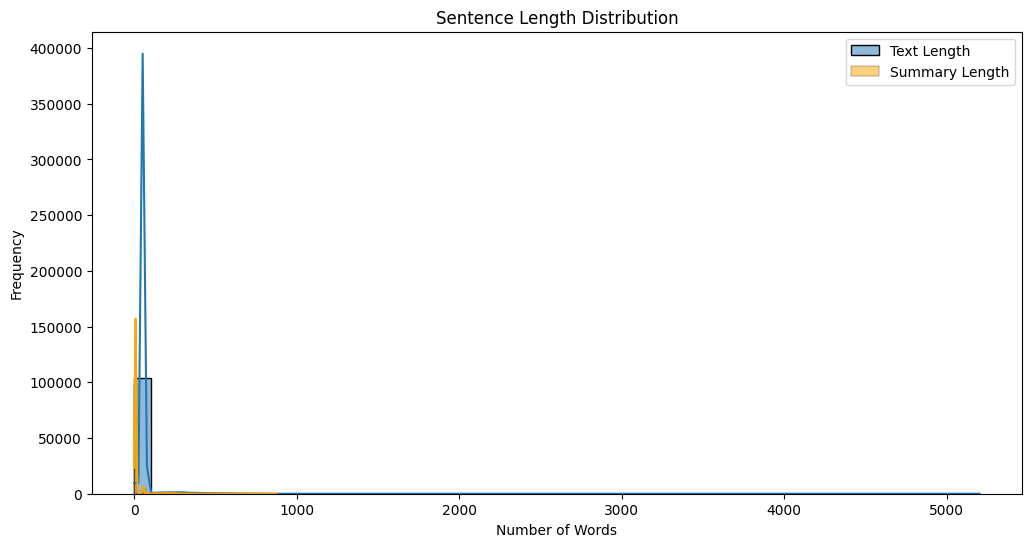

In [ ]:

plt.figure(figsize=(12, 6))
sns.histplot(data['text_length'], kde=True, bins=50, label='Text Length')
sns.histplot(data['summary_length'], kde=True, bins=50, color='orange', label='Summary Length')
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

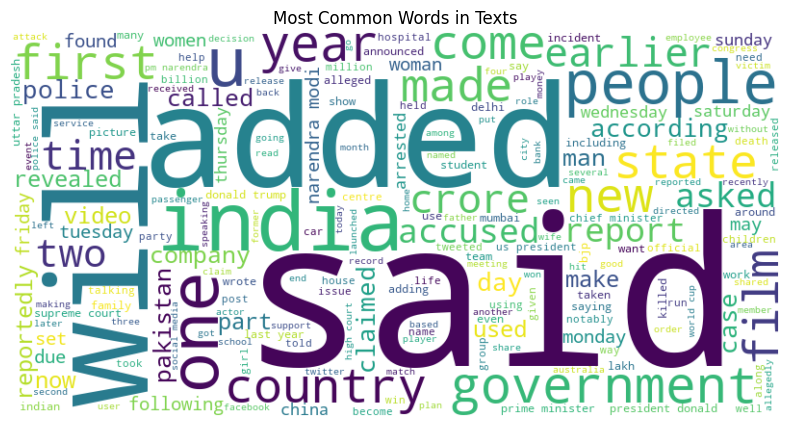

In [ ]:

text_data = ' '.join(data['cleaned_text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Texts')
plt.show()

In [ ]:

train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:

print(f"\nSize of the train dataset: {len(train_dataset)}")
print(f"Size of the test dataset: {len(test_dataset)}")


Size of the train dataset: 96996
Size of the test dataset: 10778


## Loading BioBERT Model And Configure the Model

In [ ]:

model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name)

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.sep_token_id


assert model.config.decoder_start_token_id is not None, "decoder_start_token_id is not set!"
assert model.config.pad_token_id is not None, "pad_token_id is not set!"
assert model.config.eos_token_id is not None, "eos_token_id is not set!"

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key

## Tokenization

In [ ]:

def tokenize_function(examples):
    inputs = tokenizer(
        examples['cleaned_text'],
        padding="max_length",
        truncation=True,
        max_length=256
    )
    targets = tokenizer(
        examples['cleaned_summary'],
        padding="max_length",
        truncation=True,
        max_length=150
    )
    inputs['labels'] = targets['input_ids']
    return inputs

# Prepare dataset
dataset = Dataset.from_pandas(data[['cleaned_text', 'cleaned_summary']])
dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.train_test_split(test_size=0.1, seed=42)

Map:   0%|          | 0/107774 [00:00<?, ? examples/s]

## Training the BioBERT Model

In [ ]:

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=torch.cuda.is_available()
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer
)


trainer.train()
model.save_pretrained("./fine_tuned_biobert")

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Pas

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:623: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itsel

Epoch,Training Loss,Validation Loss
1,0.535500,0.485160
2,0.439700,0.426688
3,0.393300,0.409784


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:623: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itsel

In [ ]:

print("Training Arguments:")
print(training_args)

Training Arguments:
Seq2SeqTrainingArguments(
_n_gpu=2,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
eval_use_gather_object=False,
ev

In [ ]:

print("\nTrainer Configuration:")
print(trainer)


Trainer Configuration:


## Generating Summaries

In [ ]:

trained_model_path = "./fine_tuned_biobert"


model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = BertTokenizer.from_pretrained(model_name)


try:
    model = EncoderDecoderModel.from_pretrained(trained_model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise


model.config.decoder_start_token_id = tokenizer.cls_token_id or 101  
model.config.pad_token_id = tokenizer.pad_token_id or 0             
model.config.eos_token_id = tokenizer.sep_token_id or 102           
model.config.bos_token_id = tokenizer.cls_token_id or 101           


print("Updated Configuration:")
print("Decoder Start Token ID:", model.config.decoder_start_token_id)
print("PAD Token ID:", model.config.pad_token_id)
print("EOS Token ID:", model.config.eos_token_id)
print("BOS Token ID:", model.config.bos_token_id)


model.save_pretrained(trained_model_path)
tokenizer.save_pretrained(trained_model_path)


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  

def summarize_user_input(input_text):
    """Generate summary using the BioBERT model."""
    
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=256,
        truncation=True,
        padding="max_length"
    ).to(device)  
    
    model.eval()
    with torch.no_grad():
        summary_ids = model.generate(
            inputs.input_ids,
            max_length=150,
            num_beams=4,
            early_stopping=True,
            decoder_start_token_id=model.config.decoder_start_token_id  
        )
    biobert_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return biobert_summary


test_text = "The CRISPR-Cas9 gene-editing technology has radically transformed molecular biology and genetic engineering, offering unprecedented precision and versatility. This paper delves into the mechanics of CRISPR-Cas9, highlighting its ability to target specific DNA sequences and introduce modifications with remarkable accuracy. Initially discovered in bacteria as a defense mechanism against viruses, CRISPR has now become a cornerstone of modern genetics, enabling scientists to cut, replace, or insert genes in a variety of organisms. In medical applications, CRISPR is particularly promising in treating genetic diseases such as sickle cell anemia and cystic fibrosis, where precise alterations to the genome could potentially correct genetic mutations. Moreover, the paper discusses ongoing clinical trials where CRISPR is being tested for its efficacy in combating certain types of cancer. Despite its potential, CRISPR's ethical implications are also a point of contention, particularly regarding germline editing, which could affect future generations. These concerns are addressed through discussions on regulatory frameworks and the need for stringent oversight to balance innovation with caution."
summary = summarize_user_input(test_text)
print("\nGenerated Summary:")
print(summary)


Model loaded successfully.
Updated Configuration:
Decoder Start Token ID: 101
PAD Token ID: 0
EOS Token ID: 102
BOS Token ID: 101

Generated Summary:
crispr is a cornerr on the genomes of modern genetic engineering technology which is the firstever gene editing technology which could be introduced in medical applications in medical applications this paper describes the ability to cut down the genes in a variety of organisms which could correct genes in a variety of organisms which could correct genes in a variety of organisms


In [ ]:

test_text = "As global temperatures rise and weather patterns become more erratic due to climate change, agricultural systems are facing unprecedented challenges. This paper investigates the long-term effects of climate change on crop production worldwide, particularly focusing on staple crops such as wheat, rice, and maize. Using a combination of climate modeling, crop simulation models, and case studies from diverse geographical regions, the research identifies significant trends in crop yield reductions linked to extreme weather events, such as prolonged droughts, excessive rainfall, and heatwaves. For example, regions that are heavily dependent on rain-fed agriculture are seeing a decrease in productivity due to changing precipitation patterns, while areas with high temperature variability are seeing reduced yields due to heat stress on crops. Furthermore, the paper discusses the socio-economic consequences of these declines in agricultural productivity, particularly in developing countries where food security is already a critical issue. Adaptation strategies, such as drought-resistant crop varieties and innovative irrigation techniques, are explored as potential solutions to mitigate the effects of climate change on agriculture."
summary = summarize_user_input(test_text)
print("\nGenerated Summary:")
print(summary)


Generated Summary:
this paper examines the impact of climate change on crop production on crop production on crop production on crop production on crop production worldwide the results show that climate change is being seen in the climate change climate change climate change is being seen in a combination of climate change and heatwaves and heatwaves and heatwaves and heatwaves and heatwaves and heatwaves and heatwaves and heatwaves and heatwaves and heatwaves and heatwaves and heatwaves and heatwaves and heatwaves are expected to be seen in the climate change climate change caused by heatwaves and maize and maize and maize and maize and maize and maize and maize and maize and maize and maize and maize and maize and maize


In [ ]:


def summarize_user_input(input_text):
    """Generate summary using the BioBERT model."""
    
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=256,
        truncation=True,
        padding="max_length"
    ).to(device)  
    model.eval()
    with torch.no_grad():
        summary_ids = model.generate(
            inputs.input_ids,
            max_length=150,  
            num_beams=3,  
            early_stopping=True,
            no_repeat_ngram_size=2, 
            decoder_start_token_id=model.config.decoder_start_token_id  
        )
    biobert_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return biobert_summary

# Test the summarization function
test_text = """As global temperatures rise and weather patterns become more erratic due to climate change, agricultural systems are facing unprecedented challenges. This paper investigates the long-term effects of climate change on crop production worldwide, particularly focusing on staple crops such as wheat, rice, and maize. Using a combination of climate modeling, crop simulation models, and case studies from diverse geographical regions, the research identifies significant trends in crop yield reductions linked to extreme weather events, such as prolonged droughts, excessive rainfall, and heatwaves. For example, regions that are heavily dependent on rain-fed agriculture are seeing a decrease in productivity due to changing precipitation patterns, while areas with high temperature variability are seeing reduced yields due to heat stress on crops. Furthermore, the paper discusses the socio-economic consequences of these declines in agricultural productivity, particularly in developing countries where food security is already a critical issue. Adaptation strategies, such as drought-resistant crop varieties and innovative irrigation techniques, are explored as potential solutions to mitigate the effects of climate change on agriculture."""

summary = summarize_user_input(test_text)
print("\nGenerated Summary:")
print(summary)


Generated Summary:
this paper examines the effects of climate change on crop production on crops growing in a combination of wheat and rice and maize and crops in the region of developing countries the results show that the longterm drought patterns are associated with heatwaves and heathites and droughts the study investigated the impact of the climate warming patterns on the crop growth rate of crops across the country crore crore and the global warming rate and temperature reductions from the world and zealand maize crops and agricultural growth patterns in this study we report the effect of global temperatures and weather events on agricultural production and climate impact on rices heat stress patterns and increased drought events in different regions of rural areas and inaugurates the drought pattern of crop


In [ ]:
model.save_pretrained(trained_model_path)
tokenizer.save_pretrained(trained_model_path)

('./fine_tuned_biobert/tokenizer_config.json',
 './fine_tuned_biobert/special_tokens_map.json',
 './fine_tuned_biobert/vocab.txt',
 './fine_tuned_biobert/added_tokens.json')

## Evaluation with ROUGE Score and Ranking

In [ ]:

def summarize_user_input(input_text):
    """Generate summary using the BioBERT model."""
    
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=256,
        truncation=True,
        padding="max_length"
    ).to(device)  

    model.eval()
    with torch.no_grad():
        summary_ids = model.generate(
            inputs.input_ids,
            max_length=150,  
            num_beams=3,  
            early_stopping=True,
            no_repeat_ngram_size=2,  
            decoder_start_token_id=model.config.decoder_start_token_id 
        )
    biobert_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return biobert_summary


def calculate_rouge(reference_summary, generated_summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_summary, generated_summary)
    return scores


def calculate_pagerank(texts):
    
    graph = nx.Graph()
    for i in range(len(texts)):
        for j in range(i+1, len(texts)):
            graph.add_edge(i, j)
    return nx.pagerank(graph)


def calculate_test_rank(pagerank_scores):
    return np.argsort(list(pagerank_scores.values()))[::-1]


generated_summaries = []
rouge_scores = []
pagerank_scores = []
test_ranks = []

for i in range(5):
    print(f"Enter the text for input {i+1}:")
    user_input = input()

   
    summary = summarize_user_input(user_input)
    generated_summaries.append(summary)

    
    rouge_score = calculate_rouge(user_input, summary)
    rouge_scores.append(rouge_score)

    print("\nGenerated Summary:")
    print(summary)
    print("\nROUGE Scores:")
    print(rouge_score)

    
    pagerank_scores = calculate_pagerank(generated_summaries)
    test_rank = calculate_test_rank(pagerank_scores)

Enter the text for input 1:


 As global temperatures rise and weather patterns become more erratic due to climate change, agricultural systems are facing unprecedented challenges. This paper investigates the long-term effects of climate change on crop production worldwide, particularly focusing on staple crops such as wheat, rice, and maize. Using a combination of climate modeling, crop simulation models, and case studies from diverse geographical regions, the research identifies significant trends in crop yield reductions linked to extreme weather events, such as prolonged droughts, excessive rainfall, and heatwaves. For example, regions that are heavily dependent on rain-fed agriculture are seeing a decrease in productivity due to changing precipitation patterns, while areas with high temperature variability are seeing reduced yields due to heat stress on crops. Furthermore, the paper discusses the socio-economic consequences of these declines in agricultural productivity, particularly in developing countries wh


Generated Summary:
this paper examines the effects of climate change on crop production on crops growing in a combination of wheat and rice and maize and crops in the region of developing countries the results show that the longterm drought patterns are associated with heatwaves and heathites and droughts the study investigated the impact of the climate warming patterns on the crop growth rate of crops across the country crore crore and the global warming rate and temperature reductions from the world and zealand maize crops and agricultural growth patterns in this study we report the effect of global temperatures and weather events on agricultural production and climate impact on rices heat stress patterns and increased drought events in different regions of rural areas and inaugurates the drought pattern of crop

ROUGE Scores:
{'rouge1': Score(precision=0.5426356589147286, recall=0.4046242774566474, fmeasure=0.4635761589403974), 'rouge2': Score(precision=0.171875, recall=0.127906976

 Nanotechnology has emerged as a transformative tool in the fight against cancer, with its ability to manipulate materials at the molecular and atomic levels enabling novel approaches to treatment. This paper explores the diverse applications of nanotechnology in cancer therapy, particularly in drug delivery systems. By using nanoparticles, researchers are able to create targeted drug carriers that can specifically deliver chemotherapy agents directly to tumor cells, minimizing damage to surrounding healthy tissue and reducing side effects. Additionally, nanoparticles are being employed in imaging and diagnostic techniques, allowing for earlier detection of cancers and more precise monitoring of tumor progression. The paper further discusses the design of multifunctional nanoparticles that can simultaneously deliver drugs, monitor tumor cells, and release therapeutic agents in response to environmental stimuli. Despite the promising advances, the paper also highlights the challenges an


Generated Summary:
nanotechnology has emerged as a transformative tool in the fight against cancer therapy and its ability to deliver chemotherapy agents to tumor cells the technology is able to create targeted drugs directly to cancer cells which can deliver drugs to tumors and reduce the quality of cancers the study describes the design of nanoparticles that can be used as targeted drug delivery systems to monitor cancer cancer progression the new technology has led to the development of a platform for the delivery of materials to patients in cancer treatment and safety of these drugs in this paper we describe the concept of the novel technology which allows the use of novel applications to improve the safety and efficacy of drugs and minimize the risk of tumor progression in clinical practice the project is designed

ROUGE Scores:
{'rouge1': Score(precision=0.664179104477612, recall=0.5144508670520231, fmeasure=0.5798045602605864), 'rouge2': Score(precision=0.3007518796992481, reca

 Artificial intelligence (AI) is rapidly transforming healthcare by enhancing diagnostic capabilities, personalizing treatments, and streamlining administrative processes. This paper examines the applications of AI across various domains, from medical imaging and diagnostic algorithms to robotic surgery and patient management systems. AI's ability to analyze large datasets has made it particularly useful in identifying patterns and making predictions that were previously impossible for human clinicians to detect. For example, AI algorithms can now analyze medical images to detect early signs of diseases such as cancer and neurological disorders, improving the accuracy and speed of diagnoses. Moreover, AI-powered systems are increasingly being used to tailor personalized treatment plans based on individual patient data, leading to more effective and targeted therapies. However, the paper also raises significant ethical concerns surrounding AI in healthcare, including the need to protect


Generated Summary:
ai technologybased technology has made the application of an automated diagnostic algorithm to robotic surgery and patient management in healthcare and medical imaging systems the technology is being used to detect diseases that could be used for human health management systems which may perpetuate disparities in health data and technology management system the paper describes a new technology based on medical images and diagnostic algorithms to identify patients who are diagnosed avt technology in the health care system and to ensure the use of diagnostics to monitor patients with disease management and making decisions on the treatment of patients in medical services and device managements the system is designed to inform the medical datasets to track patients and patients to prevent diseases and safety and use therapies to predict patients

ROUGE Scores:
{'rouge1': Score(precision=0.6230769230769231, recall=0.42408376963350786, fmeasure=0.5046728971962617), 'roug

 Microplastics, tiny plastic particles less than 5 millimeters in size, have become ubiquitous in marine environments, posing a significant threat to aquatic life and, by extension, human health. This paper reviews the sources and distribution of microplastics in oceans and freshwater systems, highlighting the ways in which these pollutants are ingested by marine organisms, from plankton to large marine mammals. The study shows that microplastics can disrupt the digestive systems of marine animals, leading to reduced feeding efficiency, growth inhibition, and even death in some species. Additionally, these particles can accumulate toxic substances, which are then transferred up the food chain, ultimately reaching humans through seafood consumption. The research also investigates the potential health risks associated with microplastic ingestion, such as inflammation, hormonal disruption, and cancer. The paper emphasizes the urgent need for comprehensive solutions to reduce microplastic 


Generated Summary:
microplastics have become ubiquitous indian organisms in marine systems to disrupt the digestion of microbial systems in ocean and freshwater systems this paper describes the impact of small plastics in seafood on marine organisms and food waste disposal in oceans and aquatic systems the study shows that microorganisms are ingested by marine animals and may disrupt their digested systems through seawater and water in the present study the process of removing micronutrients from marine environments and environmental conditions of marine ecosystems are being used as a threat to marine tissues and fishing the food consumption and death of the marine environment the paper reviews the issue of environmental health and health risk to aquatic organisms through water consumption by the ocean

ROUGE Scores:
{'rouge1': Score(precision=0.6611570247933884, recall=0.425531914893617, fmeasure=0.517799352750809), 'rouge2': Score(precision=0.25833333333333336, recall=0.165775401069

 The CRISPR-Cas9 gene-editing technology has radically transformed molecular biology and genetic engineering, offering unprecedented precision and versatility. This paper delves into the mechanics of CRISPR-Cas9, highlighting its ability to target specific DNA sequences and introduce modifications with remarkable accuracy. Initially discovered in bacteria as a defense mechanism against viruses, CRISPR has now become a cornerstone of modern genetics, enabling scientists to cut, replace, or insert genes in a variety of organisms. In medical applications, CRISPR is particularly promising in treating genetic diseases such as sickle cell anemia and cystic fibrosis, where precise alterations to the genome could potentially correct genetic mutations. Moreover, the paper discusses ongoing clinical trials where CRISPR is being tested for its efficacy in combating certain types of cancer. Despite its potential, CRISPR's ethical implications are also a point of contention, particularly regarding 


Generated Summary:
crispr is a key tool for scientists in medical applications which could be transformed into the genomes of modern genetic systems the technology has become a cornerstone of scientists to cut down the genes in the diseases which may affect the cancers disease which can be used as a defense mechanism against diseases such as genetic diseases and genetic mutations in bacteria are being used to treat cancer and improve cancer in a variety of organisms this paper describes the concept of the germline editing technology the new technology which is being introduced to improve the gene expression of genes that can correct genes which have been used for the treatment of diseases in clinical trials the process of technology is also being developed to reduce the risk of disease in patients with diseases that could

ROUGE Scores:
{'rouge1': Score(precision=0.5588235294117647, recall=0.4550898203592814, fmeasure=0.5016501650165016), 'rouge2': Score(precision=0.2518518518518518, 

In [ ]:

print("\nPageRank Scores (for all 5 summaries):")
for idx, score in pagerank_scores.items():
    print(f"Summary {idx+1}: {score}")

print("\nTest Ranks (for all 5 summaries):")
for idx, rank in enumerate(test_rank):
    print(f"Rank {idx+1}: Summary {rank+1}")


PageRank Scores (for all 5 summaries):
Summary 1: 0.2
Summary 2: 0.2
Summary 3: 0.2
Summary 4: 0.2
Summary 5: 0.2

Test Ranks (for all 5 summaries):
Rank 1: Summary 5
Rank 2: Summary 4
Rank 3: Summary 3
Rank 4: Summary 2
Rank 5: Summary 1


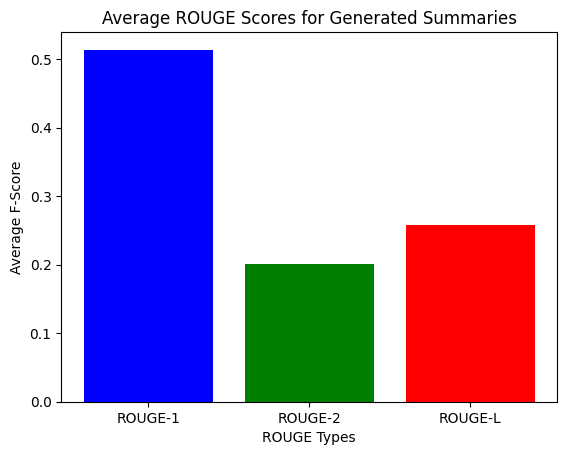

In [ ]:

rouge_1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge_2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rouge_l_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge_1 = np.mean(rouge_1_scores)
avg_rouge_2 = np.mean(rouge_2_scores)
avg_rouge_l = np.mean(rouge_l_scores)


labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
avg_scores = [avg_rouge_1, avg_rouge_2, avg_rouge_l]

plt.bar(labels, avg_scores, color=['blue', 'green', 'red'])
plt.title('Average ROUGE Scores for Generated Summaries')
plt.xlabel('ROUGE Types')
plt.ylabel('Average F-Score')
plt.show()

In [ ]:

def get_encoder_embeddings(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

    
    input_ids = encoded_input["input_ids"].to(model.device)

    
    with torch.no_grad():
        encoder_outputs = model.encoder(input_ids)

   
    embeddings = encoder_outputs.last_hidden_state.mean(dim=1)  
    return embeddings


texts = [
    "crispr is a key tool for scientists in medical applications which could be transformed into the genomes of modern genetic systems the technology has become a cornerstone of scientists to cut down the genes in the diseases which may affect the cancers disease which can be used as a defense mechanism against diseases such as genetic diseases and genetic mutations in bacteria are being used to treat cancer and improve cancer in a variety of organisms this paper describes the concept of the germline editing technology the new technology which is being introduced to improve the gene expression of genes that can correct genes which have been used for the treatment of diseases in clinical trials the process of technology is also being developed to reduce the risk of disease in patients with diseases that could",
    "Tmicroplastics have become ubiquitous indian organisms in marine systems to disrupt the digestion of microbial systems in ocean and freshwater systems this paper describes the impact of small plastics in seafood on marine organisms and food waste disposal in oceans and aquatic systems the study shows that microorganisms are ingested by marine animals and may disrupt their digested systems through seawater and water in the present study the process of removing micronutrients from marine environments and environmental conditions of marine ecosystems are being used as a threat to marine tissues and fishing the food consumption and death of the marine environment the paper reviews the issue of environmental health and health risk to aquatic organisms through water consumption by the ocean",
    "ai technologybased technology has made the application of an automated diagnostic algorithm to robotic surgery and patient management in healthcare and medical imaging systems the technology is being used to detect diseases that could be used for human health management systems which may perpetuate disparities in health data and technology management system the paper describes a new technology based on medical images and diagnostic algorithms to identify patients who are diagnosed avt technology in the health care system and to ensure the use of diagnostics to monitor patients with disease management and making decisions on the treatment of patients in medical services and device managements the system is designed to inform the medical datasets to track patients and patients to prevent diseases and safety and use therapies to predict patients",

]


embeddings = get_encoder_embeddings(texts)


similarity_matrix = cosine_similarity(embeddings.cpu().numpy())


similarity_df = pd.DataFrame(similarity_matrix, columns=["Text 1", "Text 2", "Text 3"], index=["Text 1", "Text 2", "Text 3"])


print("\nSimilarity Matrix:")
print(similarity_df)





Similarity Matrix:
          Text 1    Text 2    Text 3
Text 1  1.000000  0.828798  0.833008
Text 2  0.828798  1.000000  0.822638
Text 3  0.833008  0.822638  1.000000


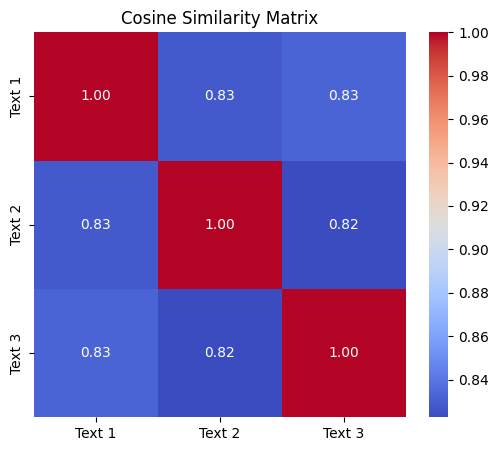

In [ ]:

plt.figure(figsize=(6, 5))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cosine Similarity Matrix")
plt.show()